In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/'

## Load EFO Ontology

In [3]:
efo = obo.read_obo('http://www.ebi.ac.uk/efo/efo.obo')
efo_root='EFO:0000001'

In [5]:
n = list(efo.nodes())

['MONDO:0002494']

In [246]:
depths = nx.single_target_shortest_path_length(efo, efo_root)
depth_dict = {source:distance for source, distance in depths}

<class 'networkx.utils.decorators.argmap'> compilation 20:3: FutureWarning: 

single_target_shortest_path_length will return a dict instead of
an iterator in version 3.5


In [247]:
def return_more_specific_code(codeA, codeB, depth_dict, study_data):
    if codeA == codeB:
        return codeA
    try:
        codeA, codeB = [code.replace('_', ':') for code in [codeA, codeB]]
    except:
        if type(codeA) == float:
            return codeB
        elif type(codeB) == float:
            return codeA
        else:
            print('TYPE_ERROR:', codeA, codeB)
    present = [code in depth_dict for code in [codeA, codeB]]
    if sum(present) == 2:

        depthA = depth_dict[codeA]
        depthB = depth_dict[codeB]
        if depthA > depthB:
            return codeA
        elif depthB > depthA:
            return codeB
        else:
            return check_study_counts(codeA, codeB, study_data)
    elif sum(present) == 1:
        return [codeA, codeB][present.index(True)]
    else:
        print(f'Neither {codeA} or {codeB} present in EFO. Returning {codeB}')
        return codeB
    
def check_study_counts(codeA, codeB, data):
    codeA, codeB = [code.replace(':', '_') for code in [codeA, codeB]]
    codeA_count = data[data.STUDY_EFO==codeA].shape[0] + data[data.TRAIT_EFO==codeA].shape[0]
    codeB_count = data[data.STUDY_EFO==codeB].shape[0] + data[data.TRAIT_EFO==codeB].shape[0]
    if codeA_count < codeB_count:
        return codeA
    if codeB_count < codeA_count:
        return codeB
    elif codeB_count == codeA_count:
        print(f'{codeA} and {codeB} have equal study counts. Returning {codeB}')
        return manually_determine_correct_code(codeA, codeB, data)

def manually_determine_correct_code(codeA, codeB, data):
    sub_data = data[(data.STUDY_EFO==codeA) & (data.TRAIT_EFO==codeB)]
    for col in ['DISEASE/TRAIT', 'MAPPED_TRAIT', 'STUDY_EFO', 'Disease trait', 'EFO term', 'TRAIT_EFO']:
        print(f'{col}:', sub_data[col].values)
    return input()
    

## Load raw data

### RAVAR

In [248]:
ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt'),sep='\t', 
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 'Trait Ontology id', 'EFO synonym', 'P-value'])
#replace '−' with '-'
ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

/tmp/ipykernel_833561/1718676493.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt'),sep='\t',


In [249]:
print('Reported traits', len(ravar_genes['Reported Trait'].unique()))
print('Total traits with Ontology', len(ravar_genes['Trait Ontology id'].unique()))
print('Total genes', len(ravar_genes['Gene Symbol'].unique()))
print('Min p-value', ravar_genes['P-value'].min())
print('Max p-value', ravar_genes['P-value'].max())

Reported traits 3049
Total traits with Ontology 1468
Total genes 12850
Min p-value 0.0
Max p-value 9.94e-05


RAVAR seems to have better EFO matching. No further work needed

### GWAS Catalog

In [250]:
def clean_gwas_catalog_data(datafile, outfile, pval_th=5e-8, include_intergenic=False):
    """Clean the GWAS Catalog data and write to a new file.

    Args:
        datafile (str): file path for GWAS Catalog data
        outfile (str): output file for cleaned data
        pval_th (float): p-value threshold for filtering
        include_intergenic (bool): whether to include intergenic associations

    Returns:
        None
    """
    cols= ['DATE', 'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_GENE', 'SNP_GENE_IDS', 'P-VALUE', 'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'INTERGENIC']    
    if include_intergenic:
        cols = cols + ['UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID', 'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE']
    data = pd.read_csv(datafile, sep="\t", usecols=cols)
    # filter on pval
    data = data[data["P-VALUE"] <= pval_th]
    # filter on gene and trait present
    data = data.dropna(subset=['SNP_GENE_IDS', "MAPPED_TRAIT_URI"])
    # filter out intergenic
    if not include_intergenic:
        data = data[data["INTERGENIC"] == 0]
    # remove associations with multiple genes
    data = data[~data["SNP_GENE_IDS"].str.contains(",")]
    # remove associations with multiple traits
    data = data[~data["MAPPED_TRAIT_URI"].str.contains(",")]
    # create trait code
    data['TRAIT_CODE'] = data['MAPPED_TRAIT_URI'].apply(lambda x: x.split('/')[-1])
    # write the cleaned file
    data.to_csv(outfile, sep="\t", index=False)

In [251]:
#clean_gwas_catalog_data(os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt'), os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt.cleanedJun17'), pval_th=1e-4)

In [252]:
gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt.cleanedJun17'), sep="\t")

In [253]:
print('Total reported traits', len(gwas_genes['DISEASE/TRAIT'].unique()))
print('Total traits with ontology', len(gwas_genes['TRAIT_CODE'].unique()))
print('Total genes', len(gwas_genes['MAPPED_GENE'].unique()))
print('Min p-value', gwas_genes['P-VALUE'].min())
print('Max p-value', gwas_genes['P-VALUE'].max())

Total reported traits 18955
Total traits with ontology 6863
Total genes 16052
Min p-value 0.0
Max p-value 1e-05


### GWAS Catalog Study info

In [254]:
if False:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'study_info.v1.0.3.1_Jun24.txt'), sep="\t", 
                            usecols=['DISEASE/TRAIT','ASSOCIATION COUNT','MAPPED_TRAIT', 'MAPPED_TRAIT_URI','STUDY ACCESSION',
                            'BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT URI','COHORT', 'FULL SUMMARY STATISTICS', 'SUMMARY STATS LOCATION'])
    trait_mappings = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'trait_mappings.txt'), sep="\t", usecols=['Disease trait', 'EFO term', 'EFO URI'])
    trait_mappings['TRAIT_EFO'] = trait_mappings['EFO URI'].apply(lambda x: x.split('/')[-1])
    trait_mappings.drop(columns=['EFO URI'], inplace=True)
    #gwas_study = gwas_study.loc[(gwas_study['MAPPED BACKGROUND TRAIT URI'].isna()) & (gwas_study['FULL SUMMARY STATISTICS'] == 'yes')]
    gwas_study = gwas_study.loc[~gwas_study['MAPPED_TRAIT_URI'].isna()]
    gwas_study = gwas_study.loc[~gwas_study["MAPPED_TRAIT_URI"].str.contains(",")]
    gwas_study['STUDY_EFO'] = gwas_study['MAPPED_TRAIT_URI'].apply(lambda x: x.split('/')[-1])
    gwas_study = gwas_study.merge(trait_mappings, left_on='DISEASE/TRAIT', right_on='Disease trait', how='left')
    gwas_study['TRAIT_CODE'] = gwas_study.apply(lambda x: return_more_specific_code(x['STUDY_EFO'], x['TRAIT_EFO'], depth_dict, gwas_study), axis=1)
    gwas_study.loc[:, ('DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION','COHORT','MAPPED BACKGROUND TRAIT URI', 'SUMMARY STATS LOCATION','TRAIT_CODE')].to_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned.txt'), sep='\t', index=False)
else:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned.txt'), sep='\t')

Restrict to those with at least one association

In [255]:
gwas_study = gwas_study.loc[gwas_study['ASSOCIATION COUNT'] >= 1]
gwas_study.shape

(52265, 7)

In [256]:
gwas_study.TRAIT_CODE.nunique()

9657

## Subset to genes in both before further filtering of trait codes. Need to remove those that are too broad

#### Convert identifiers

RAVAR

In [257]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(ravar_genes['Ensembl ID'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = ravar_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='Ensembl ID', right_on='from', how='inner')
    id_ensembl = id_ensembl[id_ensembl['Entrez'] != '']
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['Gene Symbol'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = ravar_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='Gene Symbol', right_on='from', how='inner')
    converted_ravar_genes = pd.concat([id_ensembl, id_symbol])
    converted_ravar_genes.to_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t', index=False)
else:
    converted_ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t')

GWAS Cat

In [258]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(gwas_genes['SNP_GENE_IDS'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = gwas_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='SNP_GENE_IDS', right_on='from', how='left')
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['MAPPED_GENE'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = gwas_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='MAPPED_GENE', right_on='from', how='inner')
    id_ensembl = id_ensembl[(id_ensembl['Entrez'] != '') & (~id_ensembl['Entrez'].isnull())]
    converted_gwas_genes = pd.concat([id_ensembl, id_symbol])
    converted_gwas_genes = converted_gwas_genes[converted_gwas_genes['Entrez'] != '']
    converted_gwas_genes.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt.cleanedJun17.entrez'), sep="\t", index=False)
else:
    converted_gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt.cleanedJun17.entrez'), sep="\t")

Genes in both data sets

In [259]:
print('Shared ensembl IDs:', len(set(ravar_genes['Ensembl ID']).intersection(set(gwas_genes['SNP_GENE_IDS']))))
print('Shared gene symbols:', len(set(ravar_genes['Gene Symbol']).intersection(set(gwas_genes['MAPPED_GENE']))))
print('Shared Entrez Gene IDs:', len(set(converted_ravar_genes['Entrez']).intersection(set(converted_gwas_genes['Entrez']))))

Shared ensembl IDs: 9192
Shared gene symbols: 9407
Shared Entrez Gene IDs: 9415


Map updated EFO traits for GWASCat

In [260]:
converted_gwas_genes = converted_gwas_genes.drop(columns=['TRAIT_CODE', 'MAPPED_TRAIT_URI']).merge(gwas_study.drop(columns=['COHORT', 'ASSOCIATION COUNT', 'SUMMARY STATS LOCATION' ]), on="DISEASE/TRAIT")

In [261]:
gwas_genes = gwas_genes.drop(columns=['TRAIT_CODE', 'MAPPED_TRAIT_URI']).merge(gwas_study.drop(columns=['COHORT', 'ASSOCIATION COUNT']), on="DISEASE/TRAIT")

## Data descriptions

Distribution of p-values

Text(0.5, 0.8, 'GWAS Catalog')

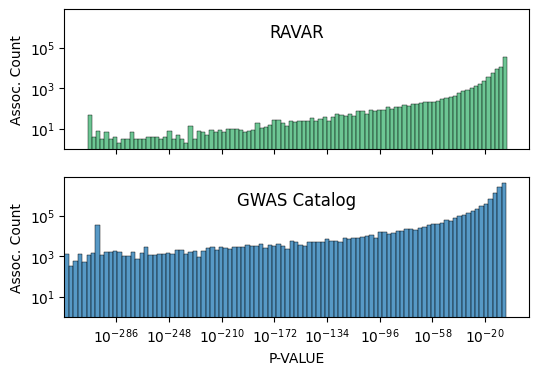

In [262]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=True)
sns.histplot(ravar_genes['P-value'], bins=100, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes['P-VALUE'], bins=100, log_scale=True, ax=ax2)

plt.yscale('log')
ax1.set_ylabel('Assoc. Count')
ax2.set_ylabel('Assoc. Count')
ax1.annotate('RAVAR', xy=(0.5, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.5, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

Distribution of genes/trait

In [263]:
rv_genes_per_trait = ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique()

In [264]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,MAPPED_TRAIT,STUDY ACCESSION,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE
0,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST001969,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0004326
1,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST001921,NaN,NaN,EFO_0004326
2,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST004715,NaN,NaN,EFO_0004326
3,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST005774,NaN,NaN,EFO_0004326
4,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST007481,NaN,NaN,EFO_0004326


Text(0.7, 0.8, 'GWAS Catalog')

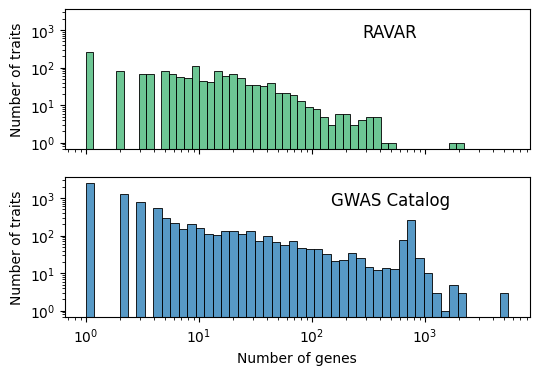

In [265]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=True)
sns.histplot(ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes.groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
plt.yscale('log')
plt.xlabel('Number of genes')
ax1.set_ylabel('Number of traits')
ax2.set_ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

Text(0.7, 0.8, 'GWAS Catalog')

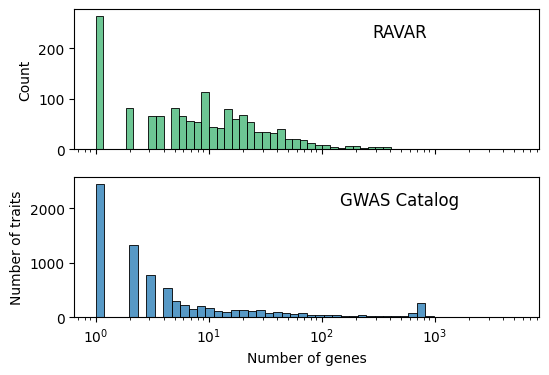

In [266]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=False)
sns.histplot(ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes.groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
#plt.yscale('log')
plt.xlabel('Number of genes')
plt.ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

### Export gene profiles

In [267]:
if False:
    for trait in tqdm(converted_ravar_genes['TRAIT_CODE'].unique()):
        gda = converted_ravar_genes.loc[converted_ravar_genes['TRAIT_CODE'] == trait, ('Gene Symbol', 'Ensembl ID','Entrez', 'P-value')]
        gda.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/', trait+ '_RV.txt'), sep='\t', index=False)

In [268]:
if False:
    for trait in tqdm(overlap_traits):
        gda = converted_gwas_genes.loc[converted_gwas_genes['TRAIT_CODE'] == trait, ('MAPPED_GENE', 'SNP_GENE_IDS', 'P-VALUE', 'Entrez')]
        gda.columns = ['Gene Symbol', 'Ensembl ID', 'P-value', 'Entrez']
        gda.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/', trait+ '_CV.txt'), sep='\t', index=False)

In [269]:
gwas_genes['TRAIT_CODE'].nunique()

7908

## Trait Overlap

No additional filtering

In [270]:
rare_traits = ravar_genes['TRAIT_CODE'].unique()
common_traits = gwas_genes['TRAIT_CODE'].unique()

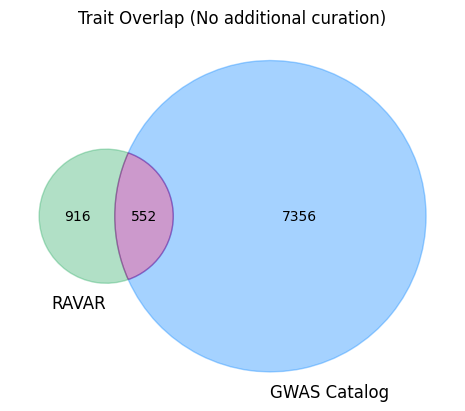

In [271]:
v = venn2([set(rare_traits), set(common_traits)], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No additional curation)')
plt.savefig(os.path.join(outdir, 'trait_overlap_venn2.png'), dpi=400, bbox_inches='tight')

No background traits

Text(0.5, 1.0, 'Trait Overlap (No background trait)')

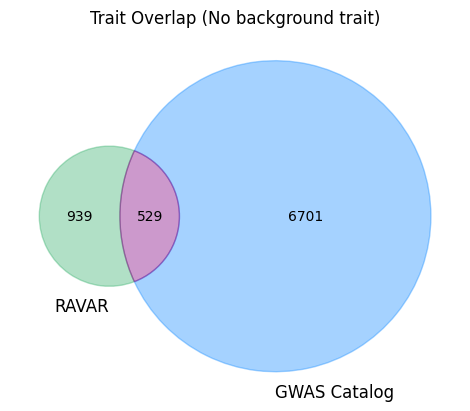

In [272]:
v = venn2([set(rare_traits), set(gwas_genes[gwas_genes['MAPPED BACKGROUND TRAIT URI'].isna()]['TRAIT_CODE'].unique())], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No background trait)')


In [273]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,MAPPED_TRAIT,STUDY ACCESSION,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE
0,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST001969,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0004326
1,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST001921,NaN,NaN,EFO_0004326
2,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST004715,NaN,NaN,EFO_0004326
3,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST005774,NaN,NaN,EFO_0004326
4,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,GCST007481,NaN,NaN,EFO_0004326


No background traits and summary stats present

Text(0.5, 1.0, 'Trait Overlap (No background trait,\n and full sumstats available)')

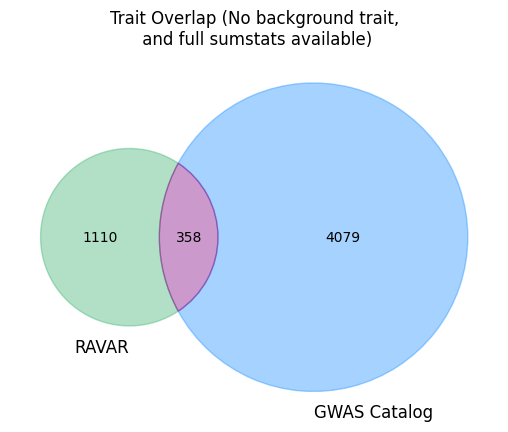

In [274]:
v = venn2([set(rare_traits), set(gwas_genes[(gwas_genes['MAPPED BACKGROUND TRAIT URI'].isna()) & (~gwas_genes['SUMMARY STATS LOCATION'].isna())]['TRAIT_CODE'].unique())], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No background trait,\n and full sumstats available)')

Statistics of overlapping traits, not accounting for summary stats/background traits

In [275]:
overlap_traits = set(rare_traits).intersection(set(common_traits))
overlap_traits_sumstats = set(rare_traits).intersection(set(gwas_genes[(gwas_genes['MAPPED BACKGROUND TRAIT URI'].isna()) & (~gwas_genes['SUMMARY STATS LOCATION'].isna())]['TRAIT_CODE'].unique()))

How many are very broad? It doesn't appear there are any really problematic ones

In [276]:
gwas_study.loc[gwas_study.TRAIT_CODE.isin(overlap_traits)]['TRAIT_CODE'].value_counts()[0:15]

TRAIT_CODE
EFO_0010226      409
EFO_0004530      224
EFO_0004611      167
EFO_0004587      164
EFO_0004340      139
MONDO_0005148    128
EFO_0004308      125
EFO_0004570       92
EFO_0004574       88
MONDO_0004975     80
EFO_0006335       76
EFO_0008317       68
MONDO_0004979     67
EFO_0006336       66
EFO_0001663       65
Name: count, dtype: int64

In [277]:
# write to file
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jun27.txt'), 'w') as f:
    for trait in overlap_traits:
        f.write(trait + '\n')

In [278]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_sumstats_Jun27.txt'), 'w') as f:
    for trait in overlap_traits_sumstats:
        f.write(trait + '\n')

Text(0.7, 0.8, 'GWAS Catalog')

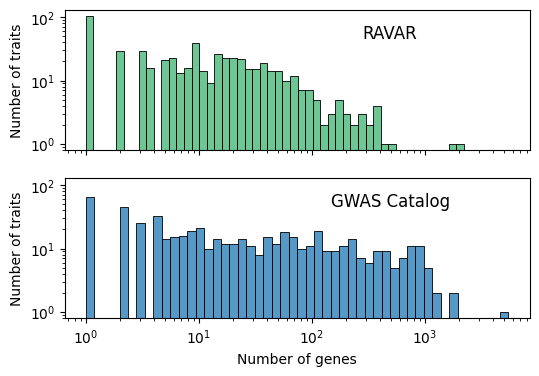

In [279]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=True)
sns.histplot(ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes[gwas_genes.TRAIT_CODE.isin(overlap_traits)].groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
plt.yscale('log')
plt.xlabel('Number of genes')
ax1.set_ylabel('Number of traits')
ax2.set_ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

Plot cumulative number of traits with > x genes

In [280]:
rv_gene_counts = ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('Trait Ontology id')['Gene Symbol'].nunique() * -1
   

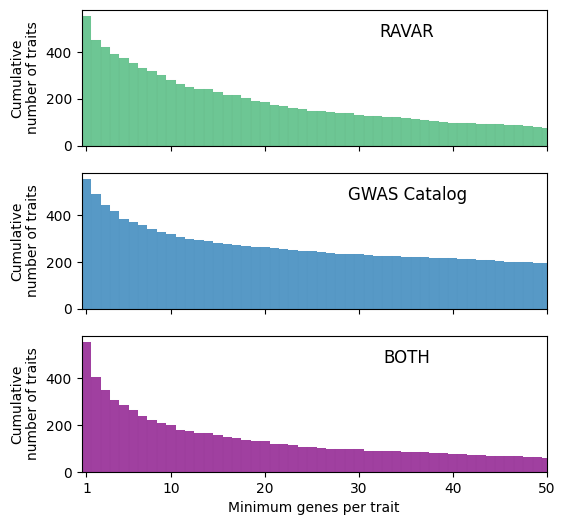

In [281]:
_, [ax1, ax2, ax3]  = plt.subplots(3, 1, figsize=(6, 6), sharex=True, sharey=True)
sns.histplot(ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('Trait Ontology id')['Gene Symbol'].nunique() *-1, bins=[-5000] +[i for i in range(-50, -1)], discrete=True, ax=ax1, color='mediumseagreen', cumulative=True)
sns.histplot(gwas_genes[gwas_genes.TRAIT_CODE.isin(overlap_traits)].groupby('TRAIT_CODE')['MAPPED_GENE'].nunique()*-1, bins=[-5000] + [i for i in range(-50, -1)], discrete=True, ax=ax2, cumulative=True)
#plt.yscale('log')
plt.xlabel('Minimum genes per trait')
ax1.set_ylabel('Cumulative\nnumber of traits')
ax2.set_ylabel('Cumulative\nnumber of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

overlap_counts = pd.concat([ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('TRAIT_CODE')['Gene Symbol'].nunique(), gwas_genes[gwas_genes.TRAIT_CODE.isin(overlap_traits)].groupby('TRAIT_CODE')['MAPPED_GENE'].nunique()], axis=1)
overlap_counts.columns = ['RAVAR', 'GWAS Catalog']
overlap_counts['Min Genes'] = overlap_counts.min(axis=1)

sns.histplot(overlap_counts['Min Genes']*-1, bins=[-5000] + [i for i in range(-50, -1)], discrete=True, cumulative=True, color='purple', ax=ax3)
plt.xlabel('Minimum genes per trait')
ax3.set_ylabel('Cumulative\nnumber of traits')
ax3.annotate('BOTH', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
plt.xlim(-50, -0.5)
# reverse the x axis
plt.gca().invert_xaxis()
_ = plt.xticks([-50, -40, -30, -20, -10, -1], [50, 40, 30, 20, 10, 1])
plt.savefig(os.path.join(outdir, 'genes_per_trait_cumulative_hists.jpg'), dpi=500, bbox_inches='tight')

In [282]:
min3_overlap_traits = overlap_counts[overlap_counts['Min Genes'] >2].index.values

In [283]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jun27_min3_genes.txt'), 'w') as f:
    for trait in min3_overlap_traits:
        f.write(trait + '\n')

## Trait Information

In [284]:
def collect_ancestor_counts(trait_set, efo):
    efo_counts = defaultdict(int)
    failed_traits = []
    for trait in list(trait_set):
        trait = trait.replace('_', ':')
        if trait in efo.nodes:
            for ancestor in list(nx.descendants(efo, trait)):
                efo_counts[ancestor] += 1
        else:
            failed_traits.append(trait)
    return efo_counts, failed_traits

def parent_counts_min_genes(overlap_counts, efo, thresholds=[1,3,5,10]):
    counts = []
    for th in thresholds:
        traits = overlap_counts[overlap_counts['Min Genes'] >= th].index.values
        efo_counts, failed_traits = collect_ancestor_counts(traits, efo)
        counts.append(efo_counts)
    counts_df = pd.DataFrame({th:efo_counts for th, efo_counts in zip(thresholds, counts)})
    return counts_df

In [285]:
all_counts = parent_counts_min_genes(overlap_counts, efo, thresholds=[1,3,5,10])

In [286]:
all_counts.loc['EFO:0000408']

1     285.0
3     214.0
5     176.0
10    117.0
Name: EFO:0000408, dtype: float64

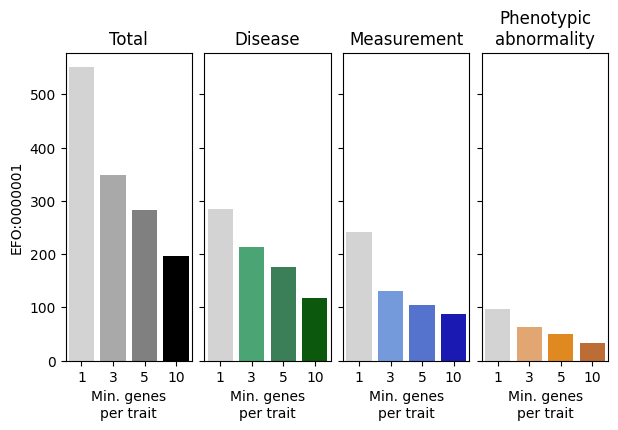

In [290]:
def plot_category_totals(all_counts, trait, title=None, palette=['lightgrey', 'mediumseagreen', 'seagreen', 'darkgreen'], thresholds=[1,3,5,10], ax=None, **kwargs):
    plot_df = all_counts.loc[trait].reset_index()
    if title is not None:
        ax.set_title(title)
    sns.barplot(data=plot_df[plot_df['index'].isin(thresholds)], x='index', y=trait, hue='index', palette=palette, ax=ax, **kwargs)
    
    
_, [ax4, ax1, ax2, ax3]  = plt.subplots(1,4, figsize=(7, 4), sharey=True, gridspec_kw={'wspace':0.1})
plot_category_totals(all_counts, 'EFO:0000001', ax=ax4, legend=False, palette=['lightgrey', 'darkgrey', 'grey', 'black'], title='Total')
plot_category_totals(all_counts, 'EFO:0000408', ax=ax1, legend=False, title='Disease')
plot_category_totals(all_counts, 'EFO:0001444', title='Measurement', palette=['lightgrey', 'cornflowerblue', 'royalblue', 'mediumblue'], ax=ax2, legend=False)
plot_category_totals(all_counts, 'HP:0000118', title='Phenotypic\nabnormality', palette=['lightgrey', 'sandybrown', 'darkorange', 'chocolate'], ax=ax3, legend=False)
for ax in [ax1, ax2, ax3, ax4]:
#     ax.set_xticks([-0.3, -0.1, 0.1, 0.3], [1,3,5,10])
    ax.set_xlabel('Min. genes\nper trait')
#     ax.set_xlim(-0.4, 0.4)
ax1.set_ylabel('Number of traits')
plt.savefig(os.path.join(outdir, 'updated_overlap_trait_counts_total_per_cat.png'), dpi=500, bbox_inches='tight')

Subcategories

In [309]:
disease_cats = [x for x in efo.predecessors('EFO:0000408')]
disease_counts = {x:all_counts.loc[x, (3)] for x in disease_cats if x in all_counts.index}
disease_counts = {efo.nodes[x]['name']:disease_counts[x] for x in disease_counts}

In [354]:
def plot_subcategories(parent, efo, all_counts, th=3, display_min=10, **kwargs):
    disease_cats = [x for x in efo.predecessors(parent)]
    disease_counts = {x:all_counts.loc[x, (th)] for x in disease_cats if x in all_counts.index}
    disease_counts = {efo.nodes[x]['name']:disease_counts[x] for x in disease_counts}
    plot_df = pd.DataFrame({'Trait Count': disease_counts}).sort_values(by='Trait Count', ascending=False).reset_index()
    sns.barplot(plot_df[plot_df['Trait Count'] >= display_min], y='index', x='Trait Count', **kwargs)
    plt.ylabel('')
    plt.xlim(0,48 )

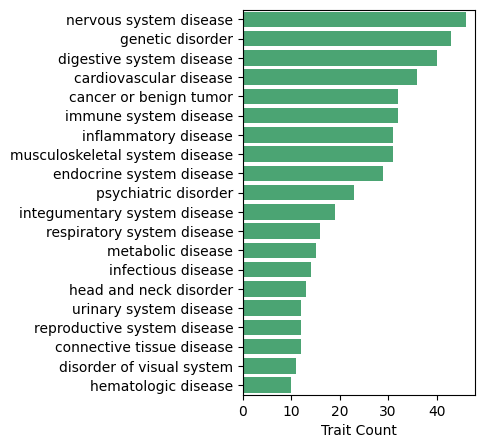

In [359]:
_ = plt.figure(figsize=(3, 5))
plot_subcategories('EFO:0000408', efo, all_counts, color='mediumseagreen')
plt.savefig(os.path.join(figdir, 'disease_counts.png'), dpi=400, bbox_inches='tight')

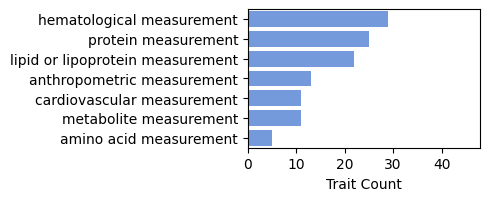

In [360]:
_ = plt.figure(figsize=(3, 1.8))
plot_subcategories('EFO:0001444', efo, all_counts, color='cornflowerblue', display_min=5)
plt.savefig(os.path.join(figdir, 'measurement_counts.png'), dpi=400, bbox_inches='tight')

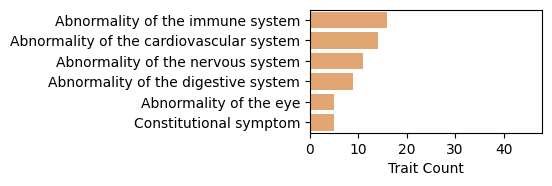

In [361]:
_ = plt.figure(figsize=(3, 1.6))
plot_subcategories('HP:0000118', efo, all_counts, color='sandybrown', display_min=5)
plt.savefig(os.path.join(figdir, 'phenoabn_counts.png'), dpi=400, bbox_inches='tight')

## Development

In [38]:
trait_info = pd.read_csv(os.path.join(datadir,'RAVAR' ,'trait_allinfo_06112024.txt'),sep='\t')
trait_info['TRAIT_CODE'] = trait_info['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

In [233]:
trait_info.head()

,Trait Ontology id,Trait Label,EFO description,EFO synonym,EFO Tree,TRAIT_CODE
0,EFO:0009827,abnormal result of diagnostic imaging,NaN,NaN,abnormal result of diagnostic imaging|test res...,EFO_0009827
1,EFO:0004536,total blood protein measurement,NaN,serum total protein;TBP,total blood protein measurement|hematological ...,EFO_0004536
2,EFO:0004838,calcium measurement,NaN,calcium levels,calcium measurement|measurement|information en...,EFO_0004838
3,EFO:0004696,sex hormone-binding globulin measurement,NaN,SHBG levels;SHBG level,sex hormone-binding globulin measurement|glyco...,EFO_0004696
4,EFO:0004532,serum gamma-glutamyl transferase measurement,NaN,GGT measurement;Gamma gluatamyl transferase le...,serum gamma-glutamyl transferase measurement|l...,EFO_0004532


In [234]:
efo_tree = defaultdict(int)
trait_weights = defaultdict(int)
failed = []
for i in tqdm(range(len(trait_info))):
    try:
        all_trees = trait_info['EFO Tree'][i].split('; ')
        unique_edges = set()
        for tree in all_trees:
            tree = tree.split('|')
            for j in range(len(tree)-1):
                unique_edges.add((tree[j], tree[j+1]))
        for j in list(unique_edges):
                efo_tree[j] += 1
                trait_weights[j[1]] += 1
    except AttributeError:
        if type(trait_info['EFO Tree'][i]) == float:
            failed.append(i)


100%|██████████| 2005/2005 [00:00<00:00, 46901.24it/s]


In [235]:
efo_graph = pd.DataFrame.from_dict(efo_tree, orient='index', columns=['Count'])
efo_graph['Child'] = [x[0] for x in efo_graph.index]
efo_graph['Parent'] = [x[1] for x in efo_graph.index]

In [236]:
efo_graph.reset_index(drop=True).to_csv(os.path.join(outdir, 'efo_graph.csv'), index=False)


In [237]:
pd.DataFrame.from_dict(trait_weights, orient='index', columns=['Count']).reset_index(drop=False).to_csv(os.path.join(outdir, 'trait_weights.csv'), index=False)

In [238]:
print('Not mapped to EFO:', len(failed), '/', len(trait_info))
print(trait_info.iloc[failed, 0:2])
print('Number of associations of unmapped traits')
ravar_genes[ravar_genes['Trait Ontology id'].isin(trait_info.iloc[failed, 0])]['Trait Ontology id'].value_counts()

Not mapped to EFO: 10 / 2005
     Trait Ontology id                                        Trait Label
235       Orphanet:846                                  Alpha-thalassemia
348     Orphanet:79161                Disorder of carbohydrate metabolism
727      Orphanet:2686                                 Cyclic neutropenia
747       Orphanet:332             Congenital intrinsic factor deficiency
928      Orphanet:2543                          Microphthalmia - cataract
1176   Orphanet:285014  Rare disease with thoracic aortic aneurysm and...
1400   Orphanet:331244  Other immunodeficiency syndrome with predomina...
1439     Orphanet:1479  Atrial septal defect - atrioventricular conduc...
1442   Orphanet:220448  Macrothrombocytopenia with mitral valve insuff...
1639   Orphanet:227535                           Hereditary breast cancer
Number of associations of unmapped traits


Trait Ontology id
Orphanet:846       65
Orphanet:79161     26
Orphanet:332       13
Orphanet:2543       9
Orphanet:2686       7
Orphanet:331244     3
Orphanet:220448     3
Orphanet:285014     2
Orphanet:1479       2
Name: count, dtype: int64

## Visualize available diseases

In [239]:
G = nx.from_pandas_edgelist(efo_graph, source='Parent', target='Child', edge_attr='Count', create_using=nx.DiGraph())

In [241]:
def evaluate_available_traits(source, overlap_counts=None, palette=['lightgrey', 'mediumseagreen', 'seagreen', 'darkgreen']):
    disease_categories = list(G.successors(source))
    category_counts = {}
    print('Getting Category Counts')
    
    for category in disease_categories:
        if overlap_counts is not None:
            category_counts[category] = get_traits_per_leaf_from_overlap(G, category, trait_info, overlap_counts, x_list=[1, 2, 3,5,10,20])
        else:
            category_counts[category] = get_traits_with_x_rvs(G, category, trait_info, ravar_genes, x_list=[1, 2, 3,5,10,20])
    category_counts_df = pd.DataFrame.from_dict(category_counts, columns=[1, 2, 3, 5, 10, 20], orient='index')
    category_counts_df['Trait'] = category_counts_df.index
    category_counts_df = category_counts_df.melt(id_vars='Trait', var_name='th', value_name='Count')
    print('Getting total counts')
    if overlap_counts is not None:
        total_disease = get_traits_per_leaf_from_overlap(G, source, trait_info, overlap_counts, x_list=[1, 2, 3,5,10,20])
    else:
        total_disease = get_traits_with_x_rvs(G, source, trait_info, ravar_genes, x_list=[1, 2, 3,5,10,20])
    
    total_disease_df = pd.DataFrame({'Total': total_disease, 'th': [1,2,3,5, 10,20], 'Trait':'Total'})
    print('Plotting')
    _, [ax1, ax2] = plt.subplots(2,1, figsize=(5, 10), height_ratios=[0.1, 1])
    sns.barplot(data=total_disease_df[total_disease_df['th'].isin([1,3,5,10])], y='Trait', x='Total', hue='th', palette=palette, ax=ax1)
    sns.barplot(data=category_counts_df[category_counts_df['th'].isin([1,3,5,10])].sort_values(by='Count', ascending=False), y='Trait', x='Count', hue='th', palette=palette, ax=ax2)
    return category_counts_df
    
def plot_category_totals(source, overlap_counts=None, palette=['lightgrey', 'mediumseagreen', 'seagreen', 'darkgreen'], ax=None, **kwargs):
    if overlap_counts is not None:
        total_disease = get_traits_per_leaf_from_overlap(G, source, trait_info, overlap_counts, x_list=[1, 2, 3,5,10,20])
    else:
        total_disease = get_traits_with_x_rvs(G, source, trait_info, ravar_genes, x_list=[1, 2, 3,5,10,20])
    total_disease_df = pd.DataFrame({'Total': total_disease, 'th': [1,2,3,5, 10,20], 'Trait':'Total'})
    print(total_disease_df)
    sns.barplot(data=total_disease_df[total_disease_df['th'].isin([1,3,5,10])], x='Trait', y='Total', hue='th', palette=palette, ax=ax, **kwargs)

   Total  th  Trait
0    142   1  Total
1    121   2  Total
2    104   3  Total
3     80   5  Total
4     45  10  Total
5     17  20  Total
   Total  th  Trait
0    407   1  Total
1    285   2  Total
2    238   3  Total
3    186   5  Total
4    125  10  Total
5     74  20  Total
   Total  th  Trait
0    211   1  Total
1    125   2  Total
2    105   3  Total
3     84   5  Total
4     69  10  Total
5     54  20  Total
   Total  th  Trait
0     44   1  Total
1     33   2  Total
2     25   3  Total
3     18   5  Total
4     10  10  Total
5      3  20  Total


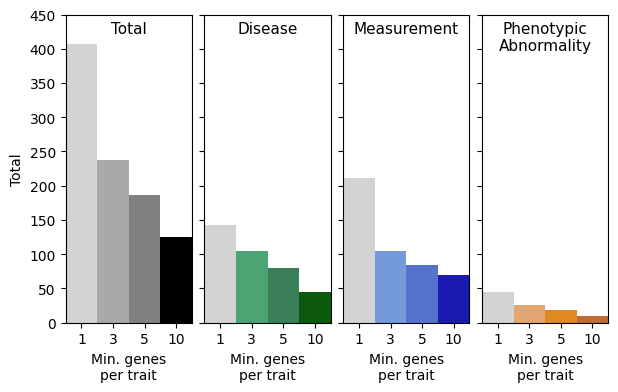

In [242]:
_, [ax4, ax1, ax2, ax3]  = plt.subplots(1,4, figsize=(7, 4), sharey=True, gridspec_kw={'wspace':0.1})
plot_category_totals('disease', overlap_counts=overlap_counts, ax=ax1, legend=False, )
plot_category_totals('experimental factor', overlap_counts=overlap_counts, ax=ax4, legend=False, palette=['lightgrey', 'darkgrey', 'grey', 'black'])
plot_category_totals('measurement', overlap_counts=overlap_counts, palette=['lightgrey', 'cornflowerblue', 'royalblue', 'mediumblue'], ax=ax2, legend=False)
plot_category_totals('Phenotypic abnormality', overlap_counts=overlap_counts, palette=['lightgrey', 'sandybrown', 'darkorange', 'chocolate'], ax=ax3, legend=False)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-0.3, -0.1, 0.1, 0.3], [1,3,5,10])
    ax.set_xlabel('Min. genes\nper trait')
    ax.set_xlim(-0.4, 0.4)
ax1.set_ylabel('Number of traits')
for i in range(4):
    [ax1, ax2, ax3, ax4][i].annotate(['Disease', 'Measurement', 'Phenotypic\nAbnormality', 'Total'][i], xy=(0.5, 0.98), xycoords='axes fraction', ha='center', va='top', fontsize=11)
plt.ylim(0, 450)
plt.savefig(os.path.join(outdir, 'overlap_trait_counts_total_per_cat.png'), dpi=500, bbox_inches='tight')

In [ ]:
plot_category_totals('experimental factor', overlap_counts=overlap_counts, legend=False) 

In [ ]:
disease_df = evaluate_available_traits('disease', overlap_counts=overlap_counts)

In [ ]:
disease_df[disease_df.th == 3].to_csv(os.path.join(outdir, 'disease_traits_with_3_rvs.csv'), index=False)

In [ ]:
abnorm_df = evaluate_available_traits('Phenotypic abnormality', overlap_counts=overlap_counts, palette=['lightgrey', 'cornflowerblue', 'royalblue', 'mediumblue'])

In [ ]:
abnorm_df[abnorm_df.th == 3].to_csv(os.path.join(outdir, 'abnormality_traits_with_3_rvs.csv'), index=False)

In [ ]:
measure_df = evaluate_available_traits('measurement', overlap_counts=overlap_counts, palette=['lightgrey', 'lightcoral', 'indianred', 'darkred'])

In [ ]:
measure_df[measure_df.th == 3].to_csv(os.path.join(outdir, 'measure_traits_with_3_rvs.csv'), index=False)

In [ ]:
for trait in tqdm(ravar_genes['Trait Ontology id'].unique()):
    gda = ravar_genes.loc[ravar_genes['Trait Ontology id'] == trait, ('Gene Symbol', 'Ensembl ID', 'P-value')]
    trait_out = trait.replace(':', '_')
    gda.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/', trait_out+ '_RV.txt'), sep='\t', index=False)

In [ ]:
trait_info[trait_info['Trait Ontology id'] == 'CHEBI:25722']

In [ ]:
ravar_genes[ravar_genes['Trait Ontology id'] == 'CHEBI:25722']